# **Retail Store Image Classification and Object Detection**

    - Amrita Chandrasekar(NH53017)
    - Yeshwanth Rayankula(PS07211)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os

# Check device: CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


# Data Preparation
Next, we prepare the dataset. This includes loading the images and applying necessary transformations. We assume your dataset is organized into train, val, and test directories.

# Data Loading and Augmentation

In [ ]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Define transformations for training, validation, and testing
train_transforms = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [ ]:

# Load the datasets
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Deep_Learning/GroceryStoreDataset/dataset/train', transform=train_transforms)
validation_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Deep_Learning/GroceryStoreDataset/dataset/val', transform=test_val_transforms)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Deep_Learning/GroceryStoreDataset/dataset/test', transform=test_val_transforms)

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2640
    Root location: /content/drive/MyDrive/Deep_Learning/GroceryStoreDataset/dataset/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-40.0, 40.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# Building and Training the model


# Model-1: Resnet

In [ ]:
from torchvision import models
import torch.nn as nn

# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)
# Freeze the parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.4MB/s]


Defining the model for resnet

In [ ]:
def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(validation_loader.dataset)
        val_acc = val_corrects.double() / len(validation_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')


Defining the model for Classification Report for Models

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_detailed_confusion_matrix(model, test_loader, device, class_names):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))  # Adjust size as needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

    # Label the axes
    ax.set_xlabel('Predicted labels', fontsize=16)
    ax.set_ylabel('True labels', fontsize=16)
    ax.set_xticklabels(class_names, fontsize=12)
    ax.set_yticklabels(class_names, fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=20)

    # Rotate the tick labels for aesthetics
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))




In [ ]:

# Set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
train_model(model, criterion, optimizer, train_loader, validation_loader)


Epoch 1/30 - Loss: 0.6099 Acc: 0.7716
Validation Loss: 0.4789 Acc: 0.8108
Epoch 2/30 - Loss: 0.4357 Acc: 0.8598
Validation Loss: 0.3550 Acc: 0.9223
Epoch 3/30 - Loss: 0.3636 Acc: 0.8848
Validation Loss: 0.3055 Acc: 0.9088
Epoch 4/30 - Loss: 0.3319 Acc: 0.8814
Validation Loss: 0.2709 Acc: 0.9324
Epoch 5/30 - Loss: 0.2949 Acc: 0.9091
Validation Loss: 0.2322 Acc: 0.9426
Epoch 6/30 - Loss: 0.2891 Acc: 0.8992
Validation Loss: 0.2144 Acc: 0.9527
Epoch 7/30 - Loss: 0.2637 Acc: 0.9129
Validation Loss: 0.1966 Acc: 0.9426
Epoch 8/30 - Loss: 0.2548 Acc: 0.9098
Validation Loss: 0.1879 Acc: 0.9527
Epoch 9/30 - Loss: 0.2612 Acc: 0.9061
Validation Loss: 0.1887 Acc: 0.9527
Epoch 10/30 - Loss: 0.2406 Acc: 0.9121
Validation Loss: 0.1776 Acc: 0.9595
Epoch 11/30 - Loss: 0.2372 Acc: 0.9152
Validation Loss: 0.1559 Acc: 0.9561
Epoch 12/30 - Loss: 0.2379 Acc: 0.9129
Validation Loss: 0.1612 Acc: 0.9662
Epoch 13/30 - Loss: 0.2203 Acc: 0.9182
Validation Loss: 0.1537 Acc: 0.9595
Epoch 14/30 - Loss: 0.2220 Acc: 0.

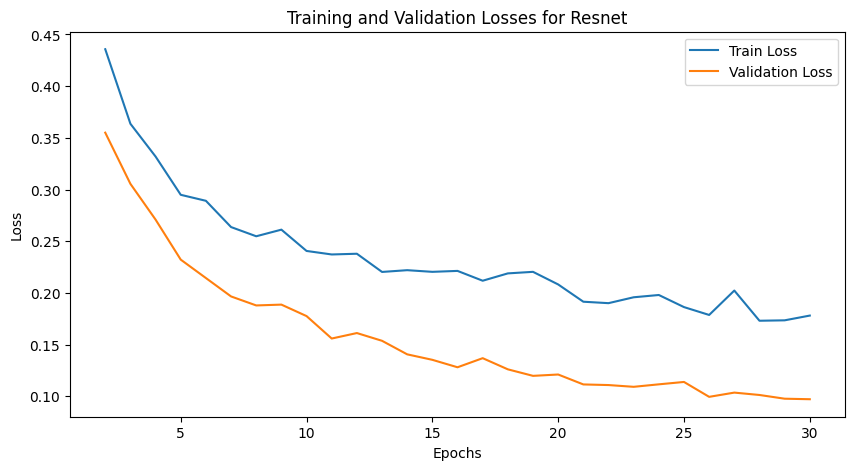

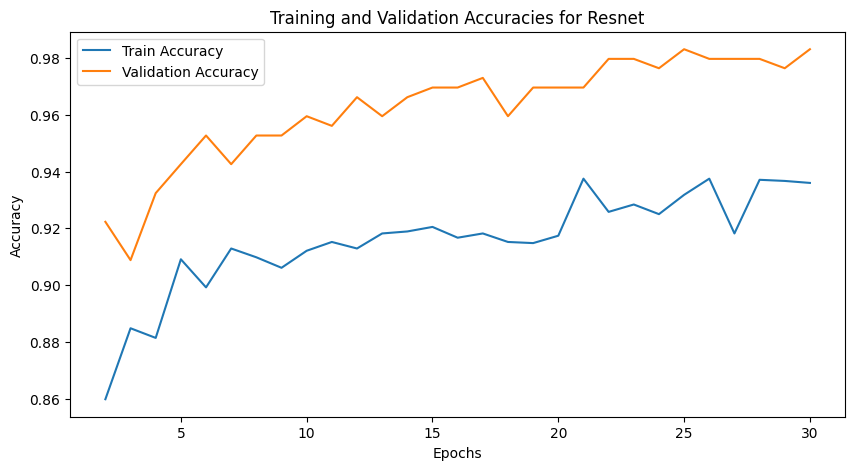

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(2, 31))  # Epochs from 2 to 30

train_losses = [0.4357, 0.3636, 0.3319, 0.2949, 0.2891, 0.2637, 0.2548, 0.2612, 0.2406, 0.2372, 0.2379, 0.2203, 0.2220, 0.2204, 0.2213, 0.2118, 0.2189, 0.2204, 0.2082, 0.1915, 0.1901, 0.1958, 0.1980, 0.1863, 0.1787, 0.2023, 0.1731, 0.1735, 0.1781]
train_accuracies = [0.8598, 0.8848, 0.8814, 0.9091, 0.8992, 0.9129, 0.9098, 0.9061, 0.9121, 0.9152, 0.9129, 0.9182, 0.9189, 0.9205, 0.9167, 0.9182, 0.9152, 0.9148, 0.9174, 0.9375, 0.9258, 0.9284, 0.9250, 0.9318, 0.9375, 0.9182, 0.9371, 0.9367, 0.9360]

validation_losses = [0.3550, 0.3055, 0.2709, 0.2322, 0.2144, 0.1966, 0.1879, 0.1887, 0.1776, 0.1559, 0.1612, 0.1537, 0.1406, 0.1353, 0.1281, 0.1369, 0.1261, 0.1198, 0.1211, 0.1115, 0.1109, 0.1092, 0.1116, 0.1139, 0.0995, 0.1036, 0.1013, 0.0977, 0.0972]
validation_accuracies = [0.9223, 0.9088, 0.9324, 0.9426, 0.9527, 0.9426, 0.9527, 0.9527, 0.9595, 0.9561, 0.9662, 0.9595, 0.9662, 0.9696, 0.9696, 0.9730, 0.9595, 0.9696, 0.9696, 0.9696, 0.9797, 0.9797, 0.9764, 0.9831, 0.9797, 0.9797, 0.9797, 0.9764, 0.9831]

plt.figure(figsize=(10, 5))

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Resnet')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies for Resnet')
plt.legend()
plt.show()


The Validation loss and accuracy and the training loss and accuracy are pretty good and are decent for image classification.

Actually the Validation accuracy is more than the training accuracy.

# Evaluating the model

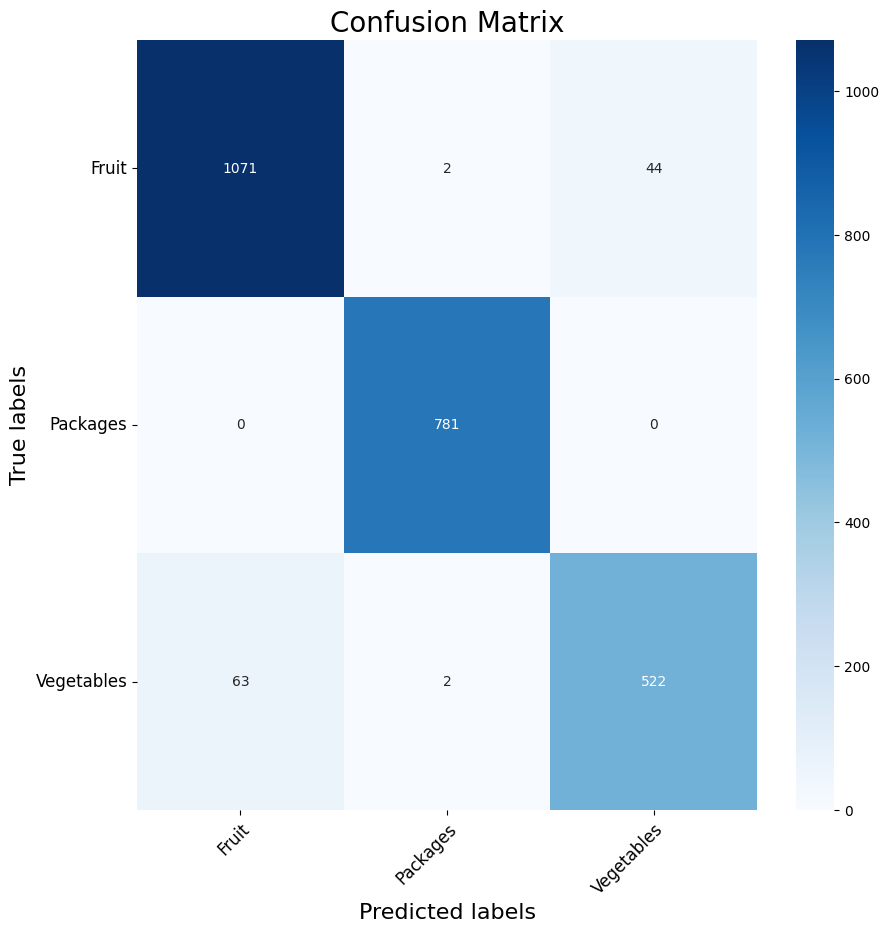

              precision    recall  f1-score   support

       Fruit       0.94      0.96      0.95      1117
    Packages       0.99      1.00      1.00       781
  Vegetables       0.92      0.89      0.91       587

    accuracy                           0.96      2485
   macro avg       0.95      0.95      0.95      2485
weighted avg       0.96      0.96      0.96      2485



In [ ]:
class_names = train_dataset.classes
plot_detailed_confusion_matrix(model, test_loader, device, class_names)

#Model-2: GoogleNet

In [ ]:
# Load pretrained GoogleNet
googlenet = models.googlenet(pretrained=True)
for param in googlenet.parameters():
    param.requires_grad = False

# Replace the final layer
googlenet.fc = nn.Linear(googlenet.fc.in_features, len(train_dataset.classes))
googlenet = googlenet.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 84.8MB/s]


# Training the GoogleNet Model

In [ ]:
import torch

def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs=30, device='cuda'):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(validation_loader.dataset)
        val_acc = val_corrects.double() / len(validation_loader.dataset)
        print(f'Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f}')



In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Load the pretrained GoogleNet model
googlenet = models.googlenet(pretrained=True)

# Freeze parameters to prevent backpropagation
for param in googlenet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

googlenet = googlenet.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=0.001)


In [ ]:
# Assuming train_loader and validation_loader are already defined
trained_googlenet = train_model(googlenet, criterion, optimizer, train_loader, validation_loader, num_epochs=30, device=device)


Epoch 1/30 - Train Loss: 0.5632 Acc: 0.7780
Validation - Loss: 0.3847 Acc: 0.8885
Epoch 2/30 - Train Loss: 0.3738 Acc: 0.8542
Validation - Loss: 0.3020 Acc: 0.9020
Epoch 3/30 - Train Loss: 0.3269 Acc: 0.8723
Validation - Loss: 0.2644 Acc: 0.9257
Epoch 4/30 - Train Loss: 0.3020 Acc: 0.8773
Validation - Loss: 0.2691 Acc: 0.8919
Epoch 5/30 - Train Loss: 0.2992 Acc: 0.8803
Validation - Loss: 0.2353 Acc: 0.9358
Epoch 6/30 - Train Loss: 0.2759 Acc: 0.8856
Validation - Loss: 0.2111 Acc: 0.9291
Epoch 7/30 - Train Loss: 0.2918 Acc: 0.8890
Validation - Loss: 0.2103 Acc: 0.9392
Epoch 8/30 - Train Loss: 0.2821 Acc: 0.8864
Validation - Loss: 0.2038 Acc: 0.9358
Epoch 9/30 - Train Loss: 0.2507 Acc: 0.8973
Validation - Loss: 0.1956 Acc: 0.9392
Epoch 10/30 - Train Loss: 0.2713 Acc: 0.8848
Validation - Loss: 0.1889 Acc: 0.9426
Epoch 11/30 - Train Loss: 0.2578 Acc: 0.8909
Validation - Loss: 0.1883 Acc: 0.9493
Epoch 12/30 - Train Loss: 0.2637 Acc: 0.8917
Validation - Loss: 0.2196 Acc: 0.9189
Epoch 13/30 -

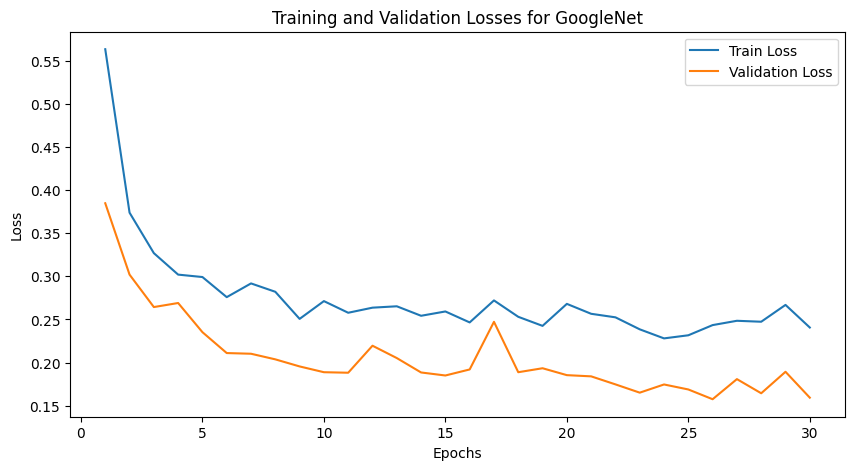

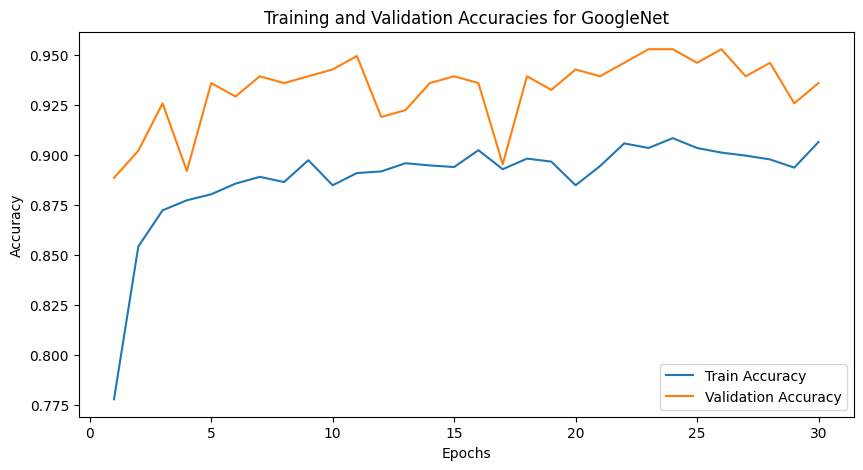

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 31))  # Epochs from 1 to 30

train_losses = [0.5632, 0.3738, 0.3269, 0.3020, 0.2992, 0.2759, 0.2918, 0.2821, 0.2507, 0.2713, 0.2578, 0.2637, 0.2653, 0.2543, 0.2593, 0.2466, 0.2721, 0.2531, 0.2426, 0.2681, 0.2566, 0.2525, 0.2386, 0.2281, 0.2317, 0.2435, 0.2485, 0.2474, 0.2669, 0.2407]
train_accuracies = [0.7780, 0.8542, 0.8723, 0.8773, 0.8803, 0.8856, 0.8890, 0.8864, 0.8973, 0.8848, 0.8909, 0.8917, 0.8958, 0.8947, 0.8939, 0.9023, 0.8928, 0.8981, 0.8966, 0.8848, 0.8943, 0.9057, 0.9034, 0.9083, 0.9034, 0.9011, 0.8996, 0.8977, 0.8936, 0.9064]

validation_losses = [0.3847, 0.3020, 0.2644, 0.2691, 0.2353, 0.2111, 0.2103, 0.2038, 0.1956, 0.1889, 0.1883, 0.2196, 0.2053, 0.1886, 0.1851, 0.1921, 0.2473, 0.1889, 0.1935, 0.1855, 0.1841, 0.1748, 0.1652, 0.1747, 0.1689, 0.1576, 0.1809, 0.1645, 0.1894, 0.1594]
validation_accuracies = [0.8885, 0.9020, 0.9257, 0.8919, 0.9358, 0.9291, 0.9392, 0.9358, 0.9392, 0.9426, 0.9493, 0.9189, 0.9223, 0.9358, 0.9392, 0.9358, 0.8953, 0.9392, 0.9324, 0.9426, 0.9392, 0.9459, 0.9527, 0.9527, 0.9459, 0.9527, 0.9392, 0.9459, 0.9257, 0.9358]

plt.figure(figsize=(10, 5))

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for GoogleNet')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies for GoogleNet')
plt.legend()
plt.show()


#

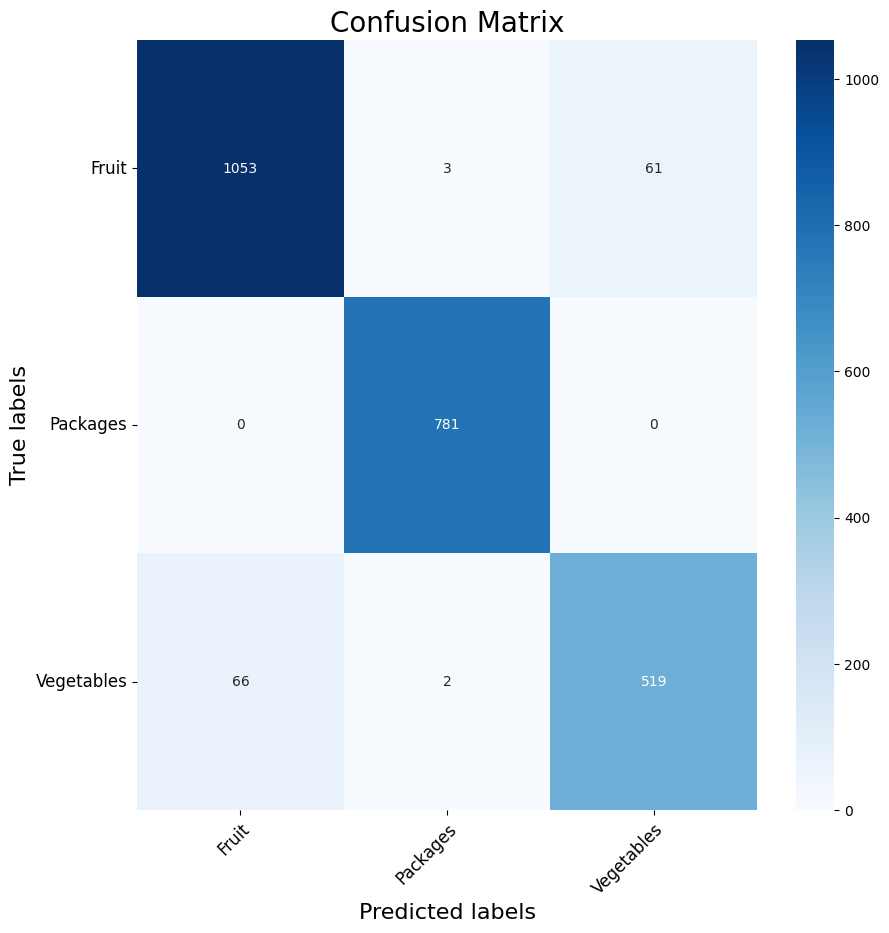

              precision    recall  f1-score   support

       Fruit       0.94      0.94      0.94      1117
    Packages       0.99      1.00      1.00       781
  Vegetables       0.89      0.88      0.89       587

    accuracy                           0.95      2485
   macro avg       0.94      0.94      0.94      2485
weighted avg       0.95      0.95      0.95      2485



In [ ]:
class_names = train_dataset.classes
plot_detailed_confusion_matrix(googlenet, test_loader, device, class_names)

# Model-3: DenseNet

In [ ]:
# Load the pretrained DenseNet model
densenet = models.densenet121(pretrained=True)

# Freeze parameters to prevent backpropagation
for param in densenet.parameters():
    param.requires_grad = False

# Replace the classifier layer to match the number of classes
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs, len(train_dataset.classes))

densenet = densenet.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 83.1MB/s]


In [ ]:
# Assuming train_loader and validation_loader are already defined
trained_densenet = train_model(densenet, criterion, optimizer, train_loader, validation_loader, num_epochs=30, device=device)


Epoch 1/30 - Train Loss: 0.4970 Acc: 0.8068
Validation - Loss: 0.2443 Acc: 0.9223
Epoch 2/30 - Train Loss: 0.2793 Acc: 0.9106
Validation - Loss: 0.1963 Acc: 0.9426
Epoch 3/30 - Train Loss: 0.2431 Acc: 0.9133
Validation - Loss: 0.2161 Acc: 0.9122
Epoch 4/30 - Train Loss: 0.2002 Acc: 0.9299
Validation - Loss: 0.1297 Acc: 0.9561
Epoch 5/30 - Train Loss: 0.2044 Acc: 0.9186
Validation - Loss: 0.1163 Acc: 0.9595
Epoch 6/30 - Train Loss: 0.1789 Acc: 0.9341
Validation - Loss: 0.1041 Acc: 0.9662
Epoch 7/30 - Train Loss: 0.1982 Acc: 0.9197
Validation - Loss: 0.1019 Acc: 0.9730
Epoch 8/30 - Train Loss: 0.1843 Acc: 0.9303
Validation - Loss: 0.1009 Acc: 0.9662
Epoch 9/30 - Train Loss: 0.1578 Acc: 0.9455
Validation - Loss: 0.0947 Acc: 0.9696
Epoch 10/30 - Train Loss: 0.1748 Acc: 0.9360
Validation - Loss: 0.0926 Acc: 0.9696
Epoch 11/30 - Train Loss: 0.1552 Acc: 0.9371
Validation - Loss: 0.0870 Acc: 0.9696
Epoch 12/30 - Train Loss: 0.1655 Acc: 0.9345
Validation - Loss: 0.0776 Acc: 0.9764
Epoch 13/30 -

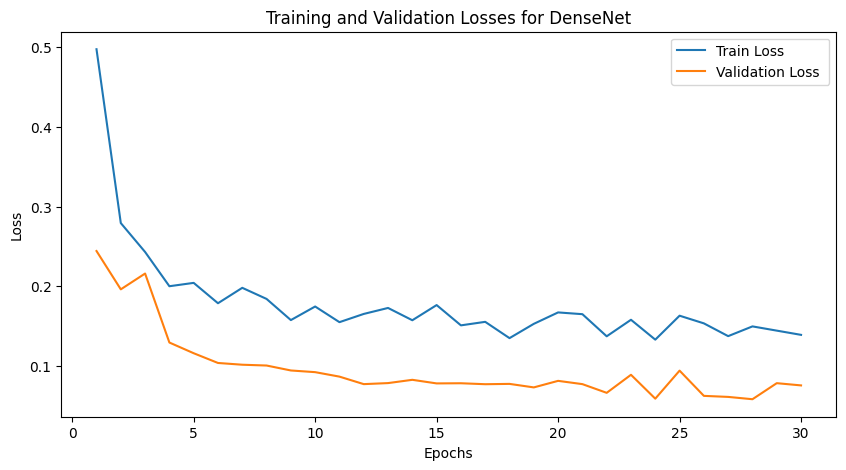

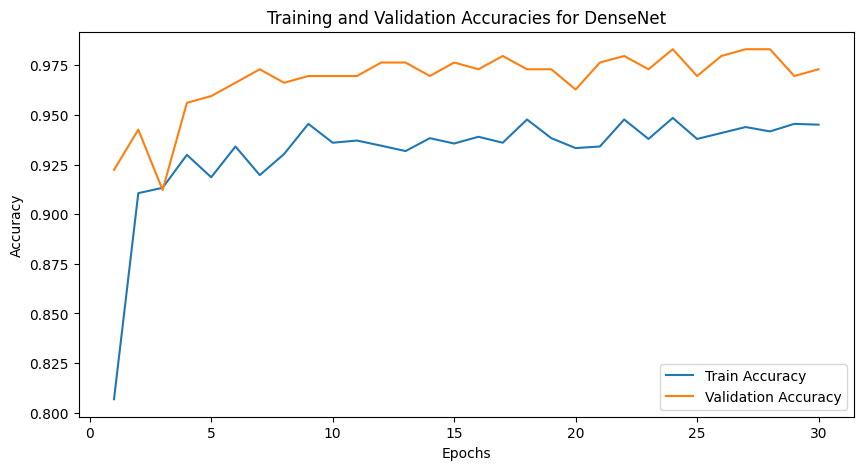

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 31))  # Epochs from 1 to 30

train_losses = [0.4970, 0.2793, 0.2431, 0.2002, 0.2044, 0.1789, 0.1982, 0.1843, 0.1578, 0.1748, 0.1552, 0.1655, 0.1730, 0.1576, 0.1766, 0.1512, 0.1556, 0.1352, 0.1531, 0.1674, 0.1652, 0.1375, 0.1582, 0.1333, 0.1633, 0.1537, 0.1377, 0.1499, 0.1446, 0.1393]
train_accuracies = [0.8068, 0.9106, 0.9133, 0.9299, 0.9186, 0.9341, 0.9197, 0.9303, 0.9455, 0.9360, 0.9371, 0.9345, 0.9318, 0.9383, 0.9356, 0.9390, 0.9360, 0.9477, 0.9383, 0.9333, 0.9341, 0.9477, 0.9379, 0.9485, 0.9379, 0.9409, 0.9439, 0.9417, 0.9455, 0.9451]

validation_losses = [0.2443, 0.1963, 0.2161, 0.1297, 0.1163, 0.1041, 0.1019, 0.1009, 0.0947, 0.0926, 0.0870, 0.0776, 0.0789, 0.0830, 0.0785, 0.0787, 0.0775, 0.0779, 0.0735, 0.0817, 0.0776, 0.0667, 0.0893, 0.0594, 0.0945, 0.0629, 0.0616, 0.0587, 0.0788, 0.0760]
validation_accuracies = [0.9223, 0.9426, 0.9122, 0.9561, 0.9595, 0.9662, 0.9730, 0.9662, 0.9696, 0.9696, 0.9696, 0.9764, 0.9764, 0.9696, 0.9764, 0.9730, 0.9797, 0.9730, 0.9730, 0.9628, 0.9764, 0.9797, 0.9730, 0.9831, 0.9696, 0.9797, 0.9831, 0.9831, 0.9696, 0.9730]

plt.figure(figsize=(10, 5))

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, validation_losses, label='Validation Loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for DenseNet')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies for DenseNet')
plt.legend()
plt.show()


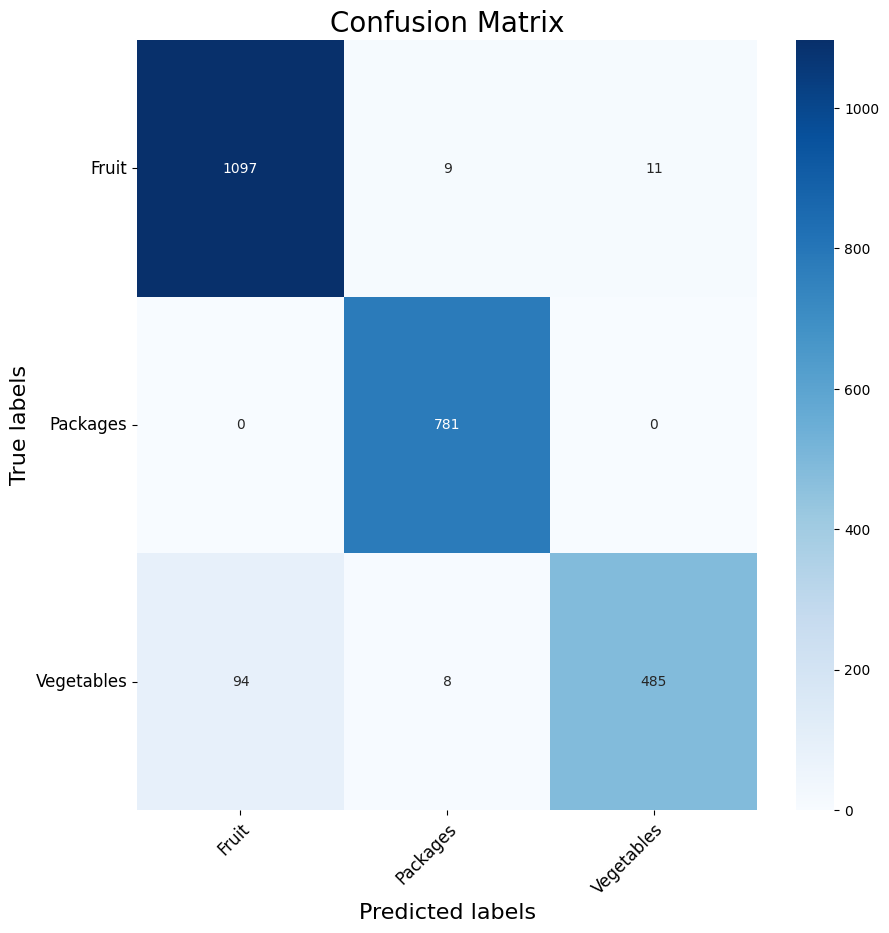

              precision    recall  f1-score   support

       Fruit       0.92      0.98      0.95      1117
    Packages       0.98      1.00      0.99       781
  Vegetables       0.98      0.83      0.90       587

    accuracy                           0.95      2485
   macro avg       0.96      0.94      0.95      2485
weighted avg       0.95      0.95      0.95      2485



In [ ]:
class_names = train_dataset.classes
plot_detailed_confusion_matrix(densenet, test_loader, device, class_names)


After Evaluating all these performances the model that fits the best for this data is densenet.

Moving further for object detection i would like to go with this model.

# Object Detection

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

class GroceryStoreDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.imgs = []
        with open(annotations_file, "r") as file:
            self.imgs = [line.strip().split() for line in file.readlines()]

    def __getitem__(self, idx):
        # Load images and bounding boxes
        img_path, x1, y1, x2, y2, label = self.imgs[idx]
        img_path = os.path.join(self.root_dir, img_path)
        img = Image.open(img_path).convert("RGB")

        # Convert everything to a torch Tensor
        boxes = torch.tensor([list(map(int, [x1, y1, x2, y2]))], dtype=torch.float32)
        labels = torch.tensor([int(label)], dtype=torch.int64)

        # Define target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Define the transformations
def get_transform():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

# Create dataset
train_dataset = GroceryStoreDataset('/content/drive/MyDrive/Deep_Learning/GroceryStoreDataset/dataset/train.txt', 'dataset/train', get_transform())
val_dataset = GroceryStoreDataset('/content/drive/MyDrive/Deep_Learning/GroceryStoreDataset/dataset/val.txt', 'dataset/val', get_transform())

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # Load a pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the classifier with a new one, that has
    # num_classes which is user-defined. Here num_classes should include the background.
    num_classes = 4  # 3 actual classes + 1 background
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Initialize the model for 3 classes + 1 background
model = get_model(num_classes=4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 74.4MB/s]


In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def train_model(model, data_loader, device, num_epochs=10):
    model.to(device)  # Move the model to the specified device
    optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_loss += losses.item()
        lr_scheduler.step()

        print(f'Epoch {epoch+1} Loss: {running_loss/len(data_loader)}')

    print("Training complete.")

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    detection_threshold = 0.5
    total_targets, correct_predictions = 0, 0

    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        model_predictions = model(images)

        for i, prediction in enumerate(model_predictions):
            pred_boxes = prediction['boxes'][prediction['scores'] >= detection_threshold].cpu()
            pred_labels = prediction['labels'][prediction['scores'] >= detection_threshold].cpu()

            target_boxes = targets[i]['boxes'].cpu()
            target_labels = targets[i]['labels'].cpu()

            # Evaluate predictions vs targets here, e.g., calculating IoU, precision, recall

    print("Evaluation complete.")

# Assuming the use of a single GPU or CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def predict(model, image_path, device):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    image = transform(image).to(device)
    model.eval()
    with torch.no_grad():
        prediction = model([image])
    return prediction

# Example of usage
image_path = "/content/drive/MyDrive/Deep_Learning/GroceryStoreDataset/dataset/test/Packages/Juice/Bravo-Apple-Juice/Bravo-Apple-Juice_001.jpg"
predictions = predict(model, image_path, device)
print(predictions)


[{'boxes': tensor([[7.9715e+01, 2.2166e+02, 1.1451e+02, 2.5178e+02],
        [1.0576e+00, 6.9969e+01, 3.7766e+01, 1.2392e+02],
        [0.0000e+00, 3.4690e+00, 1.7548e+01, 2.0607e+01],
        [1.8383e+02, 1.8655e+02, 2.8067e+02, 3.3488e+02],
        [1.8994e+02, 2.8383e+02, 2.6527e+02, 3.4518e+02],
        [0.0000e+00, 4.5129e+01, 2.3525e+01, 1.6846e+02],
        [1.5420e+00, 5.0971e+01, 4.1117e+01, 9.9495e+01],
        [0.0000e+00, 5.1080e+01, 2.7933e+01, 1.0859e+02],
        [0.0000e+00, 5.5157e+01, 9.2412e+00, 8.8795e+01],
        [1.1470e+00, 2.6006e+02, 4.8935e+01, 2.9671e+02],
        [0.0000e+00, 5.1306e+00, 9.3932e+00, 2.1115e+01],
        [9.6509e+01, 3.1023e+02, 2.0141e+02, 3.4377e+02],
        [6.8578e+01, 2.6514e+02, 2.2762e+02, 3.4035e+02],
        [3.6072e+01, 2.3065e+02, 2.1001e+02, 3.1656e+02],
        [3.3142e+02, 7.3358e+01, 3.4770e+02, 9.7191e+01],
        [2.1844e+02, 1.2902e+01, 3.4603e+02, 1.1935e+02],
        [6.1589e+01, 1.7547e+02, 2.1292e+02, 2.8866e+02],
   

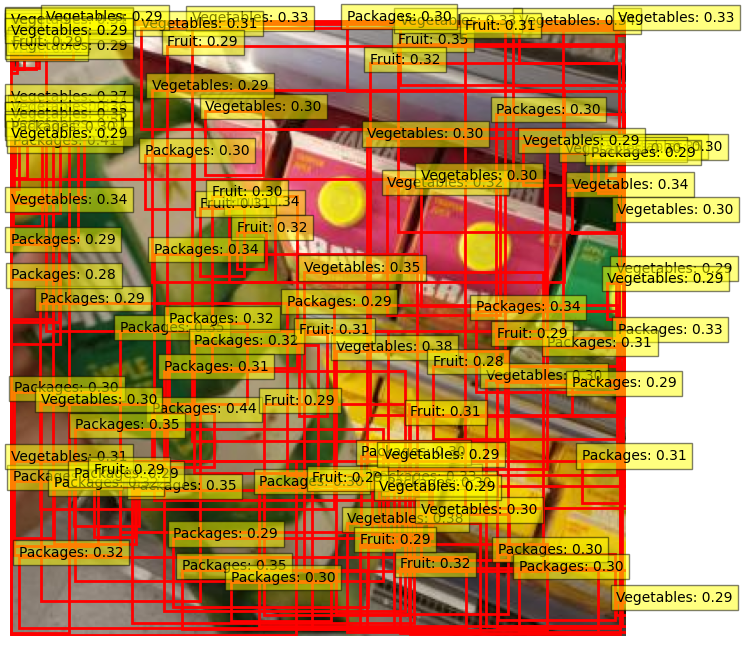

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def draw_image_with_boxes(filename, boxes, labels, scores, label_names):
    image = Image.open(filename).convert("RGB")
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, label, score in zip(boxes.tolist(), labels.tolist(), scores.tolist()):
        x1, y1, x2, y2 = box
        label_name = label_names[label] if label in label_names else 'Unknown'  # Access label name from the mapping
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, f'{label_name}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Assuming label names mapping as follows: {0: 'Background', 1: 'Fruit', 2: 'Packages', 3: 'Vegetables'}
label_names = {0: 'Background', 1: 'Fruit', 2: 'Packages', 3: 'Vegetables'}

# Assuming predictions is a list of dictionaries where each dictionary contains 'boxes', 'labels', and 'scores'
draw_image_with_boxes(image_path, predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores'], label_names)


# Sample-2


In [ ]:

image_path ="/content/drive/MyDrive/Deep_Learning/GroceryStoreDataset/dataset/test/Vegetables/Asparagus/Asparagus_001.jpg"
predictions = predict(model, image_path, device)
print(predictions)

[{'boxes': tensor([[3.8868e+00, 2.5954e+02, 3.4800e+02, 3.4800e+02],
        [0.0000e+00, 6.7360e+01, 4.2872e+01, 3.1761e+02],
        [0.0000e+00, 7.6767e+01, 1.2204e+02, 2.2515e+02],
        [3.1010e+02, 1.5520e+00, 3.4326e+02, 3.9216e+01],
        [9.8875e-01, 7.6943e+01, 4.2126e+01, 1.6236e+02],
        [8.7817e+00, 2.7874e+02, 2.4171e+02, 3.4404e+02],
        [1.9616e+02, 4.5825e+01, 2.2492e+02, 8.1373e+01],
        [1.2668e+01, 1.7803e+02, 3.1323e+02, 3.4415e+02],
        [0.0000e+00, 3.6213e+01, 1.2332e+02, 3.4800e+02],
        [8.0862e+01, 2.4791e+02, 9.8929e+01, 2.6539e+02],
        [2.4661e+02, 5.4245e+00, 3.2770e+02, 5.9307e+01],
        [1.3929e+02, 4.9614e+01, 1.6680e+02, 8.4166e+01],
        [0.0000e+00, 7.7893e+00, 3.2114e+01, 2.5637e+02],
        [3.0083e+02, 1.6283e+00, 3.4696e+02, 3.3262e+01],
        [9.6049e-01, 2.5009e+02, 7.3375e+01, 2.9675e+02],
        [8.8549e+00, 7.5009e+01, 3.7631e+01, 1.0990e+02],
        [0.0000e+00, 2.4465e+02, 8.5784e+01, 3.3788e+02],
   

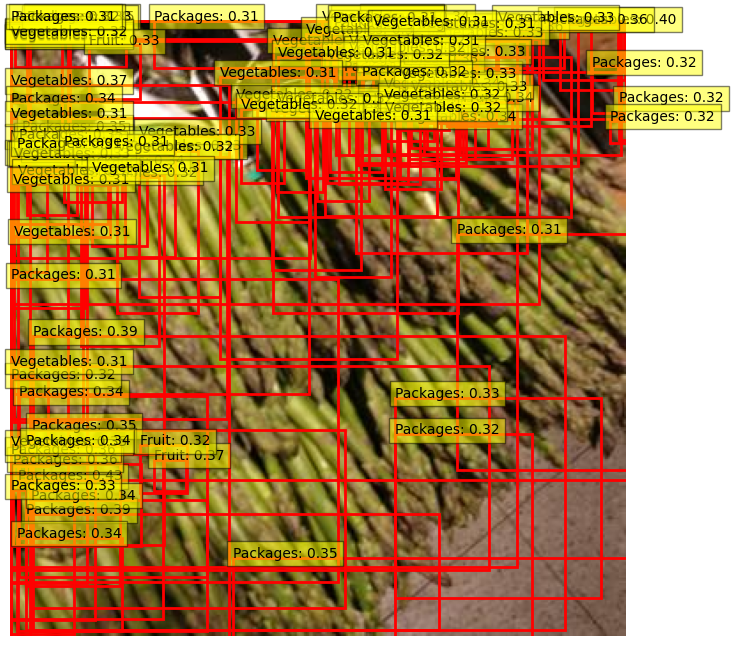

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def draw_image_with_boxes(filename, boxes, labels, scores, label_names):
    image = Image.open(filename).convert("RGB")
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, label, score in zip(boxes.tolist(), labels.tolist(), scores.tolist()):
        x1, y1, x2, y2 = box
        label_name = label_names[label] if label in label_names else 'Unknown'  # Access label name from the mapping
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, f'{label_name}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Assuming label names mapping as follows: {0: 'Background', 1: 'Fruit', 2: 'Packages', 3: 'Vegetables'}
label_names = {0: 'Background', 1: 'Fruit', 2: 'Packages', 3: 'Vegetables'}

# Assuming predictions is a list of dictionaries where each dictionary contains 'boxes', 'labels', and 'scores'
draw_image_with_boxes(image_path, predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores'], label_names)


# Conclusion

### Classification:
- Resnet (pre-trained) peformed the best when it came to image classification tasks.
- All the models performances were good but GoogleNet turned out to be a slight dissapointment.

### Object Detection
- Coming to object detection we were not able to completely fulfill the goals of this project due to the structure of our dataset.
- We also tried annotating some images but that didn't end well and serve our purpose.
- Also the Faster-RNN model did a decent job when it came to object detection.
- We can enhance the object detection and make it work as a future scope for this project.